In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops, find_contours

from skimage.exposure import rescale_intensity

from skimage.morphology import skeletonize

/Users/kuanlin/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Load in images
seed_img = plt.imread('3A.tif')
tube_img = plt.imread('3B.tif')

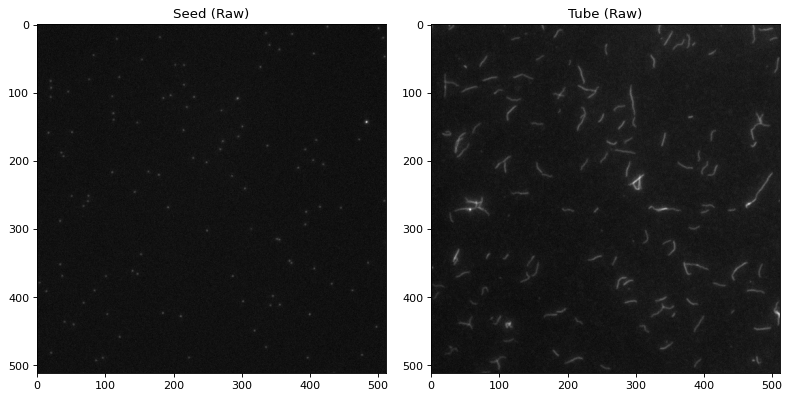

In [3]:
# Visualization Example
fig = plt.figure(figsize=(10, 5), dpi = 80)

plt.subplot(1, 2, 1)
plt.title("Seed (Raw)")
plt.imshow(seed_img, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Tube (Raw)")
plt.imshow(tube_img, cmap="gray")

plt.tight_layout()
plt.show()

In [4]:
def seed_identification(img):
    # Create binary mask
    binary = img > (img.mean() + 2 * img.std())
    # Identify connected blobs
    label_im = label(binary)
    seed_list = regionprops(label_im)
    # Remove small blobs
    seed_list = [i for i in seed_list if i.area > 5]
    return seed_list

In [5]:
def seeded_tube_identification(img, seeds):
    # Create binary mask
    binary = img > (img.mean() + 2 * img.std())
    # Identify connected blobs
    label_im = label(binary)
    tube_list = regionprops(label_im)
    # Remove small and gigantic blobs
    tube_list = [i for i in tube_list if i.area > 10 and i.area < 250]
    seeded_tubes = []
    # Create seed location map
    seed_map = np.zeros_like(binary)
    for seed in seeds:
        minr, minc, maxr, maxc = seed.bbox
        seed_map[minr:maxr,minc:maxc] = 1
    # Identify which tubes contains seeds
    for tube in tube_list:
        minr, minc, maxr, maxc = tube.bbox
        if np.sum(seed_map[minr:maxr, minc:maxc]) > 0:
            seeded_tubes.append(tube)
    return seeded_tubes

In [6]:
def dist(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

def contour_length(data):
    val = 0
    for i in range(len(data)):
        if i != len(data) - 1:
            val += dist(data[i, 0], data[i, 1], data[i+1, 0], data[i+1, 1])
    return (val/2)

def pad_image(image):
    padded = np.zeros(shape=(image.shape[0]+2, image.shape[1]+2), dtype = np.uint16)
    padded[1:image.shape[0]+1, 1:image.shape[1]+1] = image
    return padded

def tube_length_analysis(tube):
    skeleton = skeletonize(pad_image(tube.image))
    contours = find_contours(skeleton, .5, fully_connected = 'high')
    val = 0
    for contour in contours:
        val += contour_length(contour)
    return val 

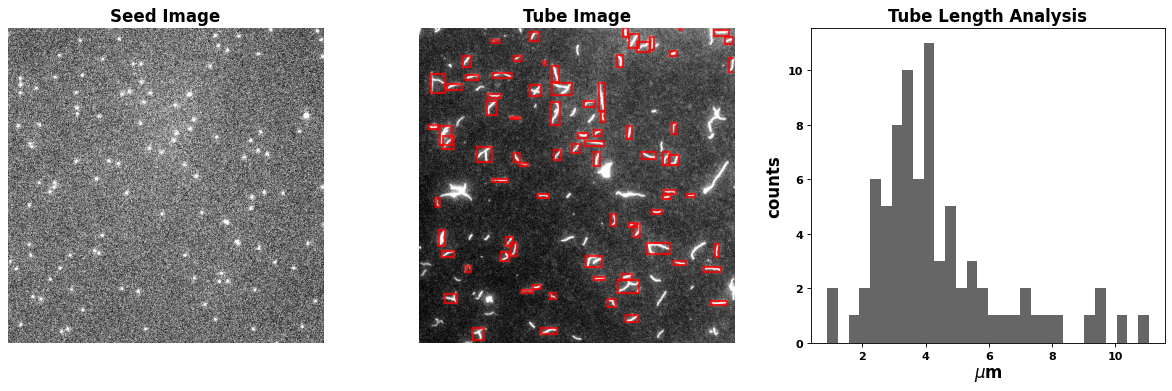

In [7]:
###########
# EXAMPLE #
###########

# FIRST, identify the seed
seed_list = seed_identification(seed_img)

# NEXT, identify seeded tubes
seeded_tubes = seeded_tube_identification(tube_img, seed_list)

# FINALLY, count the seeded tubes lengths
data = []
for tube in seeded_tubes:
    length = tube_length_analysis(tube)
    data.append(length)
    
# Transform to np array
data = np.array(data)

# Transform unit from pixel to um
data = data * 0.17

# Visualization example
figure = plt.figure(figsize=(15, 5), dpi = 80)
plt.subplot(1, 3, 1)
plt.title("Seed Image", fontsize = 15, weight = 'bold')
p2, p98 = np.percentile(seed_img, (2, 98))
img_rescale = rescale_intensity(seed_img, in_range=(p2, p98))
plt.imshow(img_rescale, cmap = "gray")
plt.axis(False)

ax = plt.subplot(1, 3, 2)
plt.title("Tube Image", fontsize = 15, weight = 'bold')
p2, p98 = np.percentile(tube_img, (2, 98))
img_rescale = rescale_intensity(tube_img, in_range=(p2, p98))
plt.imshow(img_rescale, cmap = "gray")
for i in seeded_tubes:
    minr, minc, maxr, maxc = i.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2, alpha=.8)
    ax.add_patch(rect)
plt.axis(False)

plt.subplot(1, 3, 3)
plt.title("Tube Length Analysis", fontsize = 15, weight = 'bold')
plt.hist(data, bins = 30, color = 'black', alpha = .6)
plt.xticks(fontsize = 10, weight = 'bold')
plt.yticks(fontsize = 10, weight = 'bold')
plt.xlabel("$\mu$m", fontsize = 15, weight = 'bold')
plt.ylabel("counts", fontsize = 15, weight = 'bold')

plt.tight_layout()
plt.show()

# Save data to txt file
np.savetxt("data.txt", data, fmt='%.4f')